In [1]:
import sys

package_paths = [
    '../input/pytorch-image-models-master',
]

for pth in package_paths:
    sys.path.append(pth)

In [77]:
# lib
import os
import gc
import random
import math
import time

import albumentations as A
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from albumentations.pytorch.transforms import ToTensorV2
from glob import glob
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer
import timm
from torch.utils.data import DataLoader, Dataset
from torch.optim.optimizer import Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/cassava-leaf-disease-classification/'
#data_path = '../input/debug/'
#data_path = '../input/train_images256/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 777


# CFG

In [5]:
class CFG:
    device = device
    debug = False
    
    # data set 
    size = 512
    cat_nums = None
    bs = 64 #16
    pre_load = True
    worker = 4
    max_prefetch = 16

    # model
    epochs = 25
    model_name = 'nf_resnet50'#'nf_regnet_b1'#'tf_efficientnet_b3_ns'/nf_resnet50
    hidden_size = 256
    dropout = 0.5
    
    # gradient
    iters_to_accumulate = 1
    max_grad_norm = 5
    criterion = nn.CrossEntropyLoss()
    metric = None
    smooth = 5
    
    # optimizer
    lr = 3e-4*4
    wd = 0.
    patience = 5
    optimizer = torch.optim.Adam
    optim_param = {'lr': lr, 'weight_decay': wd}
    scheduler = torch.optim.lr_scheduler.LambdaLR
    scheduler_param = {'lr_lambda': lambda epoch: 1}
    
    # snapmix
    snapmix_pct = 0.5
    snapmix_alpha = 5.0
    
if CFG.debug: data_path = '../input/debug/'
if os.name == 'nt': CFG.worker = 0

# load

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


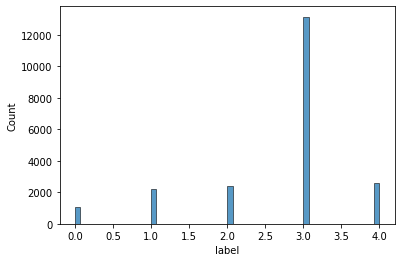

In [6]:
train_df = pd.read_csv(data_path + 'train.csv')
CFG.cat_nums = train_df.label.nunique()
with open(data_path + 'label_num_to_disease_map.json') as f:
    label2name = json.load(f)
print(label2name)
sns.histplot(train_df.label)
train_df

In [7]:
if 0:
    folds = StratifiedKFold(5)
    for n, (fold_idx) in enumerate(folds.split(train_df, train_df['label'])):
        trn_idx, val_idx = fold_idx
        print(trn_idx, val_idx)
        break

# augmentation

In [8]:
aug = A.Compose([
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
     A.HueSaturationValue(hue_shift_limit=5, 
                             sat_shift_limit=5, 
                             val_shift_limit=5),
    A.RandomGamma(),
    
])

In [9]:
def get_transforms(aug=None, size=CFG.size):
    resize = A.OneOf([
        #A.Resize(size, size, p=0.1),
        #A.RandomCrop(size, size, p=0.9),
        A.RandomResizedCrop(size, size),
    ], p=1.0) if aug else A.Resize(size, size)

    return A.Compose(
        [
            resize, 
            aug,
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ],
        p=1.0,
    )


class TrainDataset(Dataset):
    def __init__(self,
                 df,
                 features_col,
                 labels_col,
                 data_path,
                 transform=None,
                 pre_load=False):
        self.image_path = data_path + 'train_images/'
        self.image_id = df[features_col].values
        self.labels = torch.LongTensor(df[labels_col].values).to(device)
        self.transform = get_transforms(transform)
        self.pre_load = pre_load
        
        if self.pre_load:
            self.image_datas = np.array([
                cv2.imread(self.image_path + name)[..., ::-1]
                for name in self.image_id
            ])

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, idx):
        # read image
        if self.pre_load:
            x = self.image_datas[idx]
        else:
            x = cv2.imread(self.image_path + self.image_id[idx])[..., ::-1]

        x = self.transform(image=x)['image']  # .to(device)
        y = self.labels[idx]
        return x, y


class TestDataset(Dataset):
    def __init__(self,
                 data_path,
                 transform=None):
        self.image_paths = glob(data_path + 'test_images/*')
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        x = cv2.imread(self.image_paths[idx])[..., ::-1]
        x = self.transform(image=x)['image']  # .to(device)
        return x

    
# debug
if 0:
    trn_ds = TrainDataset(train_df,
                          'image_id',
                          'label',
                          data_path,
                          transform=None,
                          pre_load=False)
    trn_dl = DataLoader(trn_ds, 
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
    for x, y in trn_dl: break
    print(x.shape, y.shape)

    test_ds = TestDataset(data_path,
                          transform=None)
    test_dl = DataLoader(test_ds, batch_size=32)
    for x_ in test_dl: break
    print(x_.shape)

# model

In [10]:
def compute_metric(preds, ys):
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    if isinstance(ys, torch.Tensor):
        ys = ys.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    return (preds == ys).mean()

CFG.metric = compute_metric

In [11]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input,
                                              F.one_hot(
                                                  target, input.size(-1)),
                                              self.y,
                                              reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, reduction='mean'):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.reduction = reduction

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        if self.reduction == 'mean':
            return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
        else:
            return torch.sum(-true_dist * pred, dim=self.dim)


class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n + 1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out


class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.cat_nums,
                                             smoothing=smoothing,
                                             reduction=reduction)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss


CFG.criterion = TaylorCrossEntropyLoss(smoothing=CFG.smooth, reduction='none')

In [12]:
class Model(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 n_class=5,
                 pretrained=True,
                 freeze=False):
        super().__init__()
        backbone = timm.create_model(model_name,
                                       num_classes=5,
                                       in_chans=3,
                                       pretrained=pretrained)
        backbone = nn.Sequential(*backbone.children())
        
        self.backbone = backbone[:-1]
        classifier = nn.Sequential(*backbone[-1].children())
        self.adv = classifier[0]
        self.classifier = classifier[1]
        
    def forward(self, x):
        feats = self.backbone(x)
        x = self.adv(feats)
        x = self.classifier(x)
        return x, feats

# SnapMix

In [13]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def get_spm(input, target, model):
    imgsize = (CFG.size, CFG.size)
    bs = input.size(0)
    with torch.no_grad():
        output, fms = model(input)
        clsw = model.classifier
        weight = clsw.weight.data
        bias = clsw.bias.data
        weight = weight.view(weight.size(0), weight.size(1), 1, 1)
        fms = F.relu(fms)
        poolfea = F.adaptive_avg_pool2d(fms, (1, 1)).squeeze()
        clslogit = F.softmax(clsw.forward(poolfea))
        logitlist = []
        for i in range(bs):
            logitlist.append(clslogit[i, target[i]])
        clslogit = torch.stack(logitlist)

        out = F.conv2d(fms, weight, bias=bias)

        outmaps = []
        for i in range(bs):
            evimap = out[i, target[i]]
            outmaps.append(evimap)

        outmaps = torch.stack(outmaps)
        if imgsize is not None:
            outmaps = outmaps.view(outmaps.size(0), 1, outmaps.size(1),
                                   outmaps.size(2))
            outmaps = F.interpolate(outmaps,
                                    imgsize,
                                    mode='bilinear',
                                    align_corners=False)

        outmaps = outmaps.squeeze()

        for i in range(bs):
            outmaps[i] -= outmaps[i].min()
            outmaps[i] /= outmaps[i].sum()

    return outmaps, clslogit


def snapmix(input, target, alpha, model=None):

    r = np.random.rand(1)
    lam_a = torch.ones(input.size(0))
    lam_b = 1 - lam_a
    target_b = target.clone()

    if True:
        wfmaps, _ = get_spm(input, target, model)
        bs = input.size(0)
        lam = np.random.beta(alpha, alpha)
        lam1 = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(bs).cuda()
        wfmaps_b = wfmaps[rand_index, :, :]
        target_b = target[rand_index]

        same_label = target == target_b
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        bbx1_1, bby1_1, bbx2_1, bby2_1 = rand_bbox(input.size(), lam1)

        area = (bby2 - bby1) * (bbx2 - bbx1)
        area1 = (bby2_1 - bby1_1) * (bbx2_1 - bbx1_1)

        if area1 > 0 and area > 0:
            ncont = input[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
            ncont = F.interpolate(ncont,
                                  size=(bbx2 - bbx1, bby2 - bby1),
                                  mode='bilinear',
                                  align_corners=True)
            input[:, :, bbx1:bbx2, bby1:bby2] = ncont
            lam_a = 1 - wfmaps[:, bbx1:bbx2, bby1:bby2].sum(2).sum(1) / (
                wfmaps.sum(2).sum(1) + 1e-8)
            lam_b = wfmaps_b[:, bbx1_1:bbx2_1, bby1_1:bby2_1].sum(2).sum(1) / (
                wfmaps_b.sum(2).sum(1) + 1e-8)
            tmp = lam_a.clone()
            lam_a[same_label] += lam_b[same_label]
            lam_b[same_label] += tmp[same_label]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) /
                       (input.size()[-1] * input.size()[-2]))
            lam_a[torch.isnan(lam_a)] = lam
            lam_b[torch.isnan(lam_b)] = 1 - lam

    return input, target, target_b, lam_a.cuda(), lam_b.cuda()

In [14]:
class SnapMixLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, criterion, outputs, ya, yb, lam_a, lam_b):
        loss_a = criterion(outputs, ya)
        loss_b = criterion(outputs, yb)
        loss = torch.mean(loss_a * lam_a + loss_b * lam_b)
        return loss

CFG.snapmix_criterion = SnapMixLoss()

# optimizer

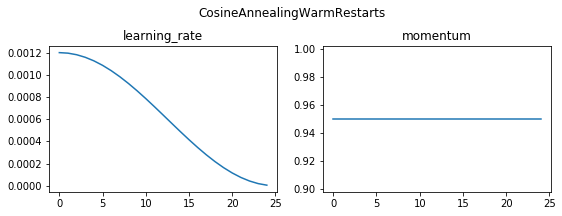

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Ranger
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': CFG.epochs,
    'T_mult': 1,
    'eta_min': 1e-6,
}
CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = nn.Linear(1, 1)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* (len(os.listdir(data_path+'train_images/')) // CFG.bs)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)
    plt.subplots_adjust(top=0.80)
    plt.show()


show_learning_rate_scheduler()

# learn

In [16]:
import threading
import queue


class MultiThreadWrapper(threading.Thread):
    def __init__(self, generator, max_prefetch=1):
        """
        This function transforms generator into a background-thead generator.
        :param generator: generator or genexp or any
        It can be used with any minibatch generator.
        It is quite lightweight, but not entirely weightless.
        Using global variables inside generator is not recommended (may rise GIL and zero-out the benefit of having a background thread.)
        The ideal use case is when everything it requires is store inside it and everything it outputs is passed through queue.
        There's no restriction on doing weird stuff, reading/writing files, retrieving URLs [or whatever] wlilst iterating.
        :param max_prefetch: defines, how many iterations (at most) can background generator keep stored at any moment of time.
        Whenever there's already max_prefetch batches stored in queue, the background process will halt until one of these batches is dequeued.
        !Default max_prefetch=1 is okay unless you deal with some weird file IO in your generator!
        Setting max_prefetch to -1 lets it store as many batches as it can, which will work slightly (if any) faster, but will require storing
        all batches in memory. If you use infinite generator with max_prefetch=-1, it will exceed the RAM size unless dequeued quickly enough.
        """
        threading.Thread.__init__(self)
        self.queue = queue.Queue(max_prefetch)
        self.generator = generator
        self.daemon = True
        self.start()
        self.exhausted = False

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def __len__(self):
        return len(self.generator)

    def __next__(self):
        if self.exhausted:
            raise StopIteration
        else:
            next_item = self.queue.get()
            if next_item is None:
                raise StopIteration
            return next_item

    def __iter__(self):
        return self

In [17]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



class EearlyStop:
    def __init__(self, patience=4, min_delta=0.005, mode='min'):
        '''
        mode: {min, max}
        '''
        self.record = np.inf if mode == 'min' else -np.inf
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.wait = 0
        
    def cal_improve(self, val_loss: float) -> bool:
        esp = 1e-8
        ratio = (val_loss - self.record + esp) / (self.record + esp)
        if ratio > 0:
            improve = False
        else:
            improve = True if -ratio > self.min_delta else False
        return improve
    
    def stop(self, val_loss: float) -> bool:
        # improve = self.cal_improve(val_loss)
        improve = True if val_loss < self.record else False
        if self.mode == 'max': improve = not improve
        
        if improve: 
            self.wait = 0
            self.record = val_loss            
        else: self.wait += 1

        
        if self.wait > self.patience: return True
        else: return False

In [18]:
class Learner():
    def __init__(self, cfg, model):
        self.cfg = cfg

        self.criterion = cfg.criterion
        self.metric = cfg.metric
        self.scaler = torch.cuda.amp.GradScaler()

        # recorder
        self.best_loss = np.inf
        self.best_score = 0
        self.epoch = 0
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.mb = master_bar(range(1, cfg.epochs + 1))
        self.mb.write(('epoch', 'train loss', 'train metric', 'val loss',
                       'val metric', 'time'),
                      table=True)
        self.early_stop = EearlyStop(patience=CFG.patience, min_delta=0.05, mode='max')

        # model
        self.device = cfg.device
        self.model = model.to(cfg.device)
        self.optimizer = cfg.optimizer(self.model.parameters(), **cfg.optim_param)
        self.scheduler = cfg.scheduler(self.optimizer, **cfg.scheduler_param)

    def trn_fn(self, trn_loader):
        self.model.train()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        
        if cfg.worker == 0 and os.name == 'nt':
            trn_loader = MultiThreadWrapper(trn_loader, cfg.max_prefetch)        
        
        trn_tqdm = progress_bar(trn_loader,
                                total=int(len(trn_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(trn_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            # forward, backward
            with torch.cuda.amp.autocast():
                rand = np.random.rand()
                if rand < self.cfg.snapmix_pct:
                    xs, ya, yb, lam_a, lam_b = snapmix(xs, 
                                                       ys, 
                                                       self.cfg.snapmix_alpha, 
                                                       self.model)
                    preds, _ = self.model(xs)
                    loss = self.cfg.snapmix_criterion(self.criterion, 
                                                      preds, 
                                                      ya, 
                                                      yb, 
                                                      lam_a, 
                                                      lam_b)                                 
                else:
                    preds, _ = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                loss_item = loss.item()
                running_loss.update(loss_item, batch_size)
            
            # backward
            loss = loss / self.cfg.iters_to_accumulate
            self.scaler.scale(loss).backward()
            
            # gradient accumulate
            if (i + 1) % self.cfg.iters_to_accumulate == 0:
                # clip grad
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                                self.cfg.max_grad_norm)
                # step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            # step scheduler if lr scheduler is onecycle
            if self.scheduler.__class__.__name__ == 'OneCycleLR':
                self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
                self.scheduler.step()
                
            # metric
            metric = self.metric(preds, ys)
            running_metric.update(metric, batch_size)
            
            # set commet on child progressbar
            self.mb.child.comment = (f'loss={loss_item:.4f}, '
                                     f'metric={metric:.4f}')

        # step scheduler if lr scheduler is not onecycle
        if self.scheduler.__class__.__name__ != 'OneCycleLR':
            self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
            self.scheduler.step()
        return running_loss.avg, running_metric.avg

    def val_fn(self, val_loader):
        self.model.eval()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        val_preds = []
        
        if cfg.worker == 0 and os.name == 'nt':
            val_loader = MultiThreadWrapper(val_loader, cfg.max_prefetch//4)

        val_tqdm = progress_bar(val_loader,
                                total=int(len(val_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(val_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            self.model.eval()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    preds, _ = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                    metric = self.metric(preds, ys)
                    
            # record
            running_loss.update(loss.item(), batch_size)
            running_metric.update(metric, batch_size)
            val_preds.append(preds.detach().cpu().numpy())

            # set commet on child progressbar
            self.mb.child.comment = (f'val_loss={loss.item():.4f}, '
                                     f'val_metric={metric:.4f}')

        val_preds = np.concatenate(val_preds)
        return running_loss.avg, running_metric.avg, val_preds

    def plot_history(self, fold_num=0):
        fig = plt.figure(figsize=(16, 3))
        fig.subplots_adjust(top=0.8)
        plt.suptitle(f'fold{fold_num}')

        # metrics
        plt.subplot(131)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_metrics'], 'C0', label='train')
        plt.plot(self.history['val_metrics'], 'C1', label='val')
        plt.title(f'Metric')
        plt.legend()
        plt.ylabel("Metric")
        plt.xlabel("Epoch")

        # loss
        plt.subplot(132)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_losses'], 'C0', label='train')
        plt.plot(self.history['val_losses'], 'C1', label='val')
        plt.title(f'Loss')
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        # lr
        plt.subplot(133)
        plt.plot(self.history['lrs'][1:], 'C0', label='lr')
        plt.title(f'Learning rate')
        plt.ylabel("lr")
        if self.history['lrs'][0] == 'OneCycleLR':
            plt.xlabel("Iteration")
        else:
            plt.xlabel("Epoch")

        plt.show()

    def fit_single(
        self,
        train_df,
        fold_idx,
        trn_loader,
        val_loader,
        fold_num=0,
    ):
        # recorder
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.history['lrs'].append(self.scheduler.__class__.__name__)
        trn_idx, val_idx = fold_idx

        # train & validate
        for epoch in self.mb:            
            self.epoch = epoch
            start_time = time.time()
            trn_loss, trn_metric = self.trn_fn(trn_loader)
            val_loss, val_metric, val_preds = self.val_fn(val_loader)

            # checkpoint
            #if val_loss < self.best_loss:
            if val_metric > self.best_score:
                logger.info(f'epoch{epoch} save best model... {val_metric}')
                #self.best_loss = val_loss
                self.best_score = val_metric
                
                oof = np.zeros((len(train_df), train_df.label.nunique()))
                oof[val_idx] = val_preds
                save_name = f"fold_{fold_num}.pth"
                self.save(save_name)
                
            # calculate time
            end_time = time.time()
            m, s = divmod(end_time - start_time, 60)

            # record
            self.history['trn_losses'].append(trn_loss)
            self.history['trn_metrics'].append(trn_metric)
            self.history['val_losses'].append(val_loss)
            self.history['val_metrics'].append(val_metric)
            self.mb.write(
                (f'{epoch}', 
                 f'{trn_loss:.6f}', 
                 f'{trn_metric:.6f}',
                 f'{val_loss:.6f}', 
                 f'{val_metric:.6f}', 
                 f'{m:.0f}:{s:.0f}'),
                table=True)
            
            # early stop
            break_flag = self.early_stop.stop(val_metric)
            if break_flag:
                logger.info(f"early stop...")
                break
                
        # record cv score
        score = self.metric(oof[val_idx], train_df.iloc[val_idx]['label'].values)
        logger.info(f"fold{fold_num} score: {score}")
        self.plot_history(fold_num)

        # del
        torch.cuda.empty_cache()

        return oof
    
    def save(self, path):
        self.model.eval()
        torch.save({
            #'model_state_dict': self.model.model.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler': self.scaler.state_dict(),
            'best_loss': self.best_loss,
            'epoch': self.epoch,
            'history': self.history,   
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler'])
        self.best_loss = checkpoint['best_loss']
        self.epoch = checkpoint['epoch']
        self.history = checkpoint['history']

```python 
folds = StratifiedKFold(5)
fold_idxes = {}
for fold_num, (fold_idx) in enumerate(folds.split(train_df, train_df['label'])):
    fold_idxes[fold_num] = fold_idx
    
import pickle
with open("fold_idxes.pkl", "wb") as f:
    pickle.dump(fold_idxes, f)
    
with open("fold_idxes.pkl", "rb") as f:
    fold_idxes = pickle.load(f)    
    ```

In [19]:
def run_kfold(cfg, train_df, n_fold=5, aug=None, pre_load=False):

    oof = np.zeros((len(train_df), train_df.label.nunique()))

    folds = StratifiedKFold(n_fold)
    for fold_num, (fold_idx) in enumerate(folds.split(train_df, train_df['label'])):
        logger.info(f'fold {fold_num}')
        trn_idx, val_idx = fold_idx

        trn_ds = TrainDataset(train_df.iloc[trn_idx],
                              'image_id',
                              'label',
                              data_path,
                              transform=aug,
                              pre_load=pre_load)
        val_ds = TrainDataset(train_df.iloc[val_idx],
                              'image_id',
                              'label',
                              data_path,
                              transform=None,
                              pre_load=pre_load)

        trn_dl = DataLoader(
            trn_ds,
            batch_size=CFG.bs,
            shuffle=True,
            drop_last=False,
            num_workers=cfg.worker,
        )
        val_dl = DataLoader(
            val_ds,
            batch_size=CFG.bs,
            drop_last=False,
            num_workers=cfg.worker,
        )

        model = Model(model_name=CFG.model_name)
        learner = Learner(CFG, model)
        _oof = learner.fit_single(train_df, fold_idx, trn_dl, val_dl, fold_num)
        oof += _oof
    score = compute_metric(oof, train_df.label.values)
    logger.info(f"CV score: {score}")
    del trn_ds, val_ds
    gc.collect()

    return oof, learner

fold 0


epoch,train loss,train metric,val loss,val metric,time
1,1.777791,0.731320,1.448172,0.855841,3:23
2,1.756197,0.803587,1.444920,0.849299,3:21
3,1.750430,0.817491,1.436597,0.875467,3:26
4,1.734222,0.822107,1.442033,0.857243,3:25
5,1.773099,0.819945,1.440960,0.859813,3:28
6,1.744477,0.828475,1.437375,0.876168,3:22
7,1.749975,0.833207,1.442973,0.863318,3:26
8,1.750618,0.827774,1.435994,0.878271,3:25
9,1.770321,0.834200,1.438539,0.871262,3:28
10,1.754065,0.838990,1.436528,0.871495,3:27


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\utl\anaconda3\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
epoch1 save best model... 0.8558411214953271
epoch3 save best model... 0.8754672897196262
epoch6 save best model... 0.8761682242990654
epoch8 save best model... 0.8782710280373832
epoch14 save best model... 0.8789719626168224
epoch16 save best model... 0.8815420560747663
epoch17 save best model... 0.8820093457943925
epoch18 save best model... 0.8824766355140187
epoch20 save best mod

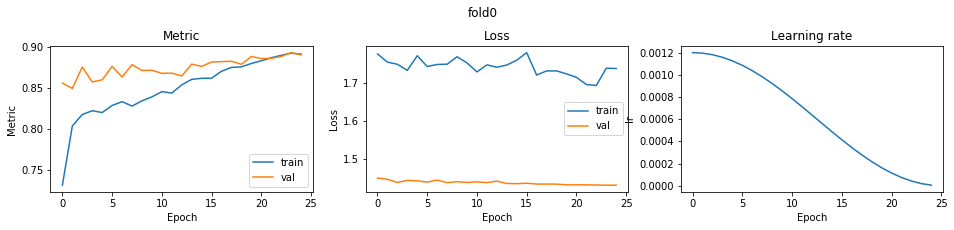

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,1.758450,0.735585,1.452814,0.841355,3:18
2,1.765803,0.800023,1.447373,0.850000,3:23
3,1.752960,0.814161,1.440511,0.861682,3:24
4,1.740514,0.817959,1.438642,0.866121,3:21
5,1.765914,0.819478,1.443759,0.860748,3:22
6,1.734326,0.828241,1.437563,0.867523,3:18
7,1.772089,0.828825,1.440880,0.865654,3:21
8,1.749735,0.833324,1.442177,0.860981,3:19
9,1.756820,0.835719,1.441052,0.867523,3:20
10,1.743590,0.834083,1.442245,0.856542,3:18


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8413551401869159
epoch2 save best model... 0.85
epoch3 save best model... 0.8616822429906542
epoch4 save best model... 0.8661214953271028
epoch6 save best model... 0.8675233644859813
epoch12 save best model... 0.8787383177570094
epoch14 save best model... 0.8850467289719626
epoch17 save best model... 0.8885514018691589
epoch19 save best model... 0.8908878504672897
epoch21 save best model... 0.8920560747663552
epoch22 save best model... 0.8941588785046729
fold1 score: 0.8941588785046729


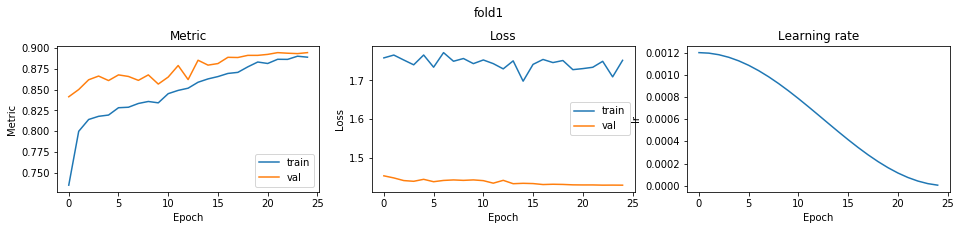

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,1.766734,0.740098,1.444746,0.862585,3:28
2,1.769393,0.803423,1.441363,0.863753,3:31
3,1.729205,0.807045,1.440463,0.863753,3:37
4,1.775497,0.812887,1.437689,0.878009,3:40
5,1.764367,0.822117,1.443736,0.858612,3:28
6,1.790828,0.814581,1.433820,0.881047,3:24
7,1.747333,0.829069,1.443743,0.854639,3:22
8,1.761697,0.827492,1.443237,0.856509,3:26
9,1.751844,0.833976,1.434813,0.875672,3:27
10,1.758110,0.837948,1.432705,0.886889,3:31


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8625847160551531
epoch2 save best model... 0.8637532133676092
epoch4 save best model... 0.8780088805795747
epoch6 save best model... 0.8810469735919607
epoch10 save best model... 0.8868894601542416
epoch13 save best model... 0.8899275531666277
epoch17 save best model... 0.8955363402664174
epoch21 save best model... 0.8960037391913999
epoch22 save best model... 0.8967048375788735
epoch23 save best model... 0.8985744332788035
epoch25 save best model... 0.8992755316662772
fold2 score: 0.8992755316662772


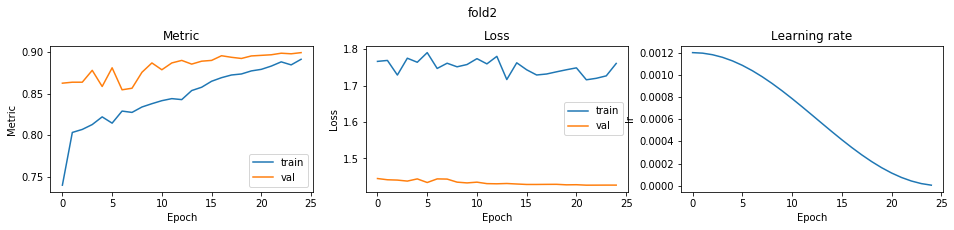

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,1.777607,0.726019,1.447735,0.853003,3:31
2,1.755174,0.800561,1.442423,0.859313,3:21
3,1.769780,0.804358,1.444827,0.845291,3:23
4,1.738120,0.819488,1.439989,0.864221,3:23
5,1.762752,0.818846,1.437250,0.872166,3:26
6,1.732153,0.829244,1.439420,0.862585,3:22
7,1.745049,0.829770,1.438350,0.870063,3:27
8,1.754084,0.831113,1.435933,0.875204,3:29
9,1.753540,0.838825,1.438139,0.867726,3:34
10,1.749151,0.837423,1.434526,0.877541,3:34


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8530030380930124
epoch2 save best model... 0.8593129235802758
epoch4 save best model... 0.8642206122925917
epoch5 save best model... 0.8721663940172938
epoch8 save best model... 0.8752044870296798
epoch10 save best model... 0.8775414816545922
epoch13 save best model... 0.8840850666043468
epoch14 save best model... 0.8880579574666978
epoch18 save best model... 0.8913297499415751
epoch20 save best model... 0.8917971488665576
fold3 score: 0.8917971488665576


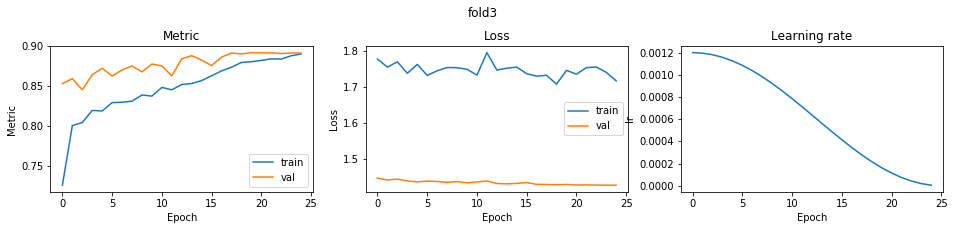

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,1.815634,0.731511,1.453172,0.837345,3:27
2,1.748632,0.804533,1.441174,0.859079,3:22
3,1.763034,0.808038,1.444650,0.847161,3:22
4,1.751107,0.818904,1.445532,0.858612,3:24
5,1.765328,0.814464,1.440039,0.864454,3:24
6,1.756697,0.831522,1.441393,0.855807,3:25
7,1.752774,0.829887,1.439839,0.873802,3:25
8,1.750409,0.830354,1.440363,0.861650,3:24
9,1.733073,0.837014,1.439664,0.867025,3:26
10,1.743519,0.840636,1.435754,0.878944,3:28


C:\Users\utl\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
epoch1 save best model... 0.8373451741060995
epoch2 save best model... 0.8590792241177845
epoch5 save best model... 0.8644543117550829
epoch7 save best model... 0.8738022902547324
epoch10 save best model... 0.8789436784295396
epoch14 save best model... 0.8796447768170134
epoch17 save best model... 0.8815143725169432
epoch18 save best model... 0.8873568590792241
epoch20 save best model... 0.8882916569291891
epoch21 save best model... 0.8917971488665576
fold4 score: 0.8917971488665576


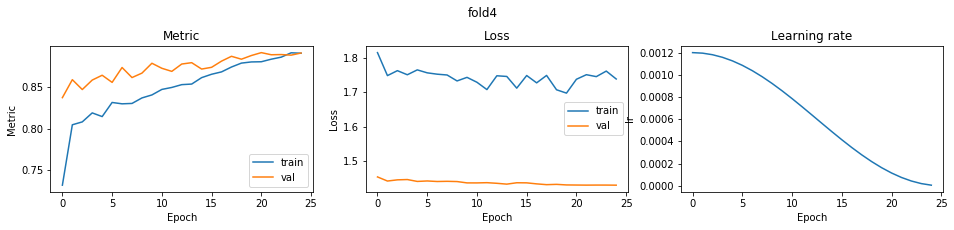

CV score: 0.8940038323129411


In [20]:
if __name__ == '__main__':
    oof, learner = run_kfold(CFG, train_df, n_fold=5, aug=aug, pre_load=CFG.pre_load)

# evaluate

In [21]:
ys = train_df.label.values
print('oof score: ', compute_metric(oof, ys))

cat_columns = [f'c{i}' for i in range(CFG.cat_nums)]
oof_df = pd.DataFrame(oof, columns=cat_columns)
oof_df = pd.concat([train_df.image_id.to_frame(), oof_df], axis=1)
oof_df.to_csv('oof_df.csv')
oof_df

oof score:  0.8940038323129411


,image_id,c0,c1,c2,c3,c4
0,1000015157.jpg,-0.093140,0.099060,-0.279785,-0.857910,-0.051300
1,1000201771.jpg,-1.290039,-1.350586,-1.289062,0.842773,-1.302734
2,100042118.jpg,-0.607910,-0.042603,-0.455322,-0.299316,0.701172
3,1000723321.jpg,-1.336914,0.862305,-1.254883,-1.278320,-1.126953
4,1000812911.jpg,-1.317383,-1.311523,-1.312500,0.843750,-1.245117
...,...,...,...,...,...,...
21392,999068805.jpg,-1.416992,-1.429688,-1.404297,0.887207,-1.406250
21393,999329392.jpg,-1.313477,-1.291992,-1.340820,0.845703,-1.280273
21394,999474432.jpg,-1.136719,0.799805,-1.095703,-0.954102,-1.050781
21395,999616605.jpg,0.007744,-0.216919,-0.489746,-0.592773,0.538574


In [22]:
oof_df.to_csv('oof_df.csv')

In [23]:
y_preds = np.argmax(oof, axis=1)
y_preds

array([1, 3, 4, ..., 1, 4, 2], dtype=int64)

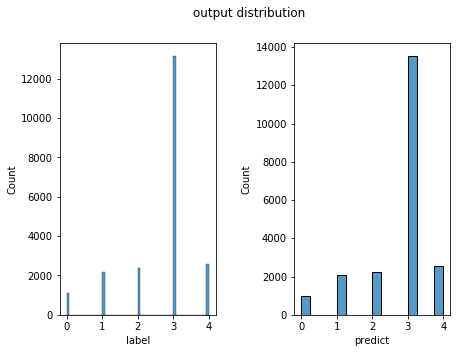

In [24]:
# compare distribution between labels and outputs
plt.figure(figsize=(7, 5))
plt.suptitle('output distribution')
plt.subplot(121)
sns.histplot(train_df.label)

plt.subplot(122)
sns.histplot(y_preds)
plt.xlabel('predict')
plt.subplots_adjust(wspace=0.5)

```python
def confusion_matrix(preds, ys):
    nunique = len(np.unique(ys))
    cm = np.zeros((nunique, nunique))
    for i, j in zip(ys, preds):
        cm[i, j] += 1
    return cm
```

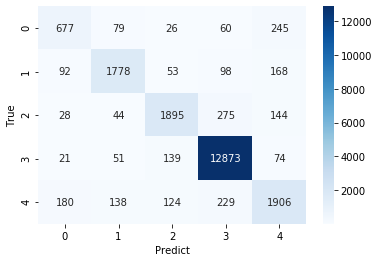

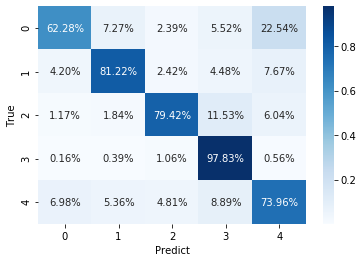

In [25]:
formats = ((None, 'd'), ('true', '.2%'))
for fmt in formats:
    cm = confusion_matrix(ys, y_preds, normalize=fmt[0])
    sns.heatmap(cm, annot=True, fmt=fmt[1], cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predict')    
    plt.show()

In [26]:
idx = np.logical_and(ys == 0, y_preds == 4)
preds_df = pd.DataFrame(y_preds[idx],
                          columns=['predict'],
                          index=np.where(idx)[0])
ys_df = pd.DataFrame(ys[idx], 
                       columns=['label'], 
                       index=np.where(idx)[0])
pd.concat([oof_df.iloc[idx], preds_df, ys_df], axis=1)

,image_id,c0,c1,c2,c3,c4,predict,label
18,1003888281.jpg,-0.047363,-0.135254,-0.635742,-0.992188,0.590332,4,0
118,102039365.jpg,-0.137939,-0.600586,-0.447998,-0.555664,0.962402,4,0
295,1052095724.jpg,-0.094666,-0.053101,-0.490723,-0.853027,0.394287,4,0
338,1060214168.jpg,-0.250244,-0.999023,-0.875488,-0.830566,0.794434,4,0
395,1071960213.jpg,-0.248657,-0.314209,-0.085205,-0.730957,0.826172,4,0
...,...,...,...,...,...,...,...,...
21144,948363257.jpg,-0.110535,-0.550781,-0.469971,-0.062500,0.286865,4,0
21256,971188113.jpg,0.279541,-0.657227,-0.649414,-0.798340,0.296875,4,0
21312,981961513.jpg,0.117493,-0.316406,-0.561523,-0.683594,0.458984,4,0
21337,986965803.jpg,0.099304,-0.601562,-0.990723,-1.412109,0.749023,4,0


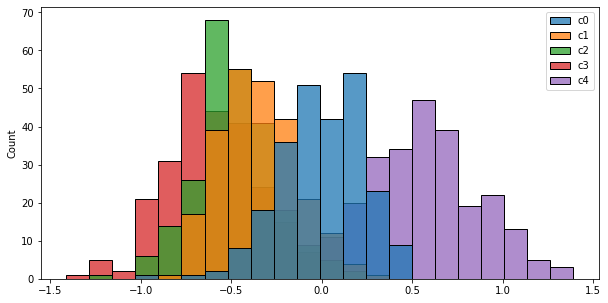

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(oof_df.iloc[idx]);
#sns.histplot(oof_df.iloc[idx][['c0', 'c4']]);

## evaluate TTA

In [63]:
CFG.tta_nums = 9

In [23]:
# create state1 models
model = Model(model_name=CFG.model_name, pretrained=False)
model.eval().to(device)
# load checkpoints
checkpoints = [torch.load(path, map_location=torch.device('cpu'))
               for path in glob('.' + '/fold*.pth')]
# create models
models = [copy.deepcopy(model)
               for _ in range(len(checkpoints))]
# load weights
for idx, checkpoint in enumerate(checkpoints):
    models[idx].load_state_dict(checkpoint['model_state_dict'])

In [75]:
oof = train_df[['image_id', 'label']].copy()

for tta in range(CFG.tta_nums):
    for fold_no, fold_idx in fold_idxes.items():
        val_idx = fold_idx[1]
        val_ds = TrainDataset(train_df.iloc[val_idx],
                              'image_id',
                              'label',
                              data_path,
                              transform=aug,
                              pre_load=False)


        val_dl = DataLoader(
            val_ds,
            batch_size=CFG.bs,
            drop_last=False,
            num_workers=cfg.worker,
        )
        val_dl = MultiThreadWrapper(val_dl, CFG.max_prefetch)
        val_tqdm = progress_bar(val_dl,
                                    total=int(len(val_dl)))
        val_preds = []
        for i, (xs, ys) in enumerate(val_tqdm):
            batch_size = len(xs)
            xs = xs.to(CFG.device)
            ys = ys.to(CFG.device)

            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    preds, _ = models[fold_no](xs)
                    preds = preds.argmax(1).detach().cpu().numpy()
                    val_preds.append(preds)
        val_preds = np.concatenate(val_preds)
        oof.loc[val_idx, f'{tta}'] = val_preds
oof

,image_id,label,0,1,2,3,4,5,6,7,8
0,1000015157.jpg,0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0
1,1000201771.jpg,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,100042118.jpg,1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,1000723321.jpg,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1000812911.jpg,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
21392,999068805.jpg,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
21393,999329392.jpg,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
21394,999474432.jpg,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21395,999616605.jpg,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0


In [78]:
oof['preds'] = stats.mode(oof[[f'{i}' for i in range(CFG.tta_nums)]].values, axis=1)[0].astype(int)  

In [79]:
(oof.preds == oof.label).mean()

0.8957330466887882

# inference

In [28]:
class TestDataset(Dataset):
    def __init__(self, test_df, image_paths, transform=None):
        self.test_names = test_df.image_id.values
        self.image_paths = image_paths
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.test_names)

    def __getitem__(self, idx):
        img_name = self.test_names[idx]
        x = cv2.imread(self.image_paths + img_name)[..., ::-1]
        x = self.transform(image=x)['image']  # .to(device)
        return x, img_name

In [38]:
class Model(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 n_class=5,
                 pretrained=True,
                 freeze=False):
        super().__init__()
        backbone = timm.create_model(model_name,
                                       num_classes=5,
                                       in_chans=3,
                                       pretrained=pretrained)
        backbone = nn.Sequential(*backbone.children())
        
        self.backbone = backbone[:-1]
        classifier = nn.Sequential(*backbone[-1].children())
        self.adv = classifier[0]
        self.classifier = classifier[1]
        
    def forward(self, x):
        feats = self.backbone(x)
        x = self.adv(feats)
        x = self.classifier(x)
        return x#, feats

In [63]:
class PredictModel(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 model_path='.',
                 n_class=5):
        super().__init__()
        # create single
        self.model = Model(model_name=model_name, pretrained=False)
        self.freeze()
        self.model.eval().to(device)

        # load checkpoints
        checkpoints = [torch.load(path, map_location=torch.device('cpu'))
                       for path in glob(model_path + '/fold*.pth')]
        # create models
        self.models = [copy.deepcopy(self.model)
                       for _ in range(len(checkpoints))]
        # load weights
        for idx, checkpoint in enumerate(checkpoints):
            self.models[idx].load_state_dict(checkpoint['model_state_dict'])

    def forward(self, x):
        with torch.no_grad():
            x = torch.mean(torch.cat([model(x)[None]
                                      for model in self.models], dim=0), dim=0)
        return x

    def freeze(self, n=None):
        for param in list(self.model.parameters())[:n]:
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [64]:
model = PredictModel(model_name=CFG.model_name)

In [45]:
# debug
if 0:
    test_path = data_path
    image_path = test_path + 'train_images/'
    test_df = copy.deepcopy(train_df)

    test_ds = TestDataset(test_df=test_df, 
                          image_paths=image_path, 
                          transform=None)
    test_dl = DataLoader(test_ds, batch_size=32)

    for xs, names in test_dl:
        xs = xs.to(device)
        preds = model(xs).detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        test_df.loc[test_df.image_id.isin(names), 'label'] = preds
    print((test_df.label.values == train_df.label.values).mean())

In [66]:
CFG.tta_nums = 9

In [67]:
aug = A.Compose([
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
     A.HueSaturationValue(hue_shift_limit=5, 
                             sat_shift_limit=5, 
                             val_shift_limit=5),
    A.RandomGamma(),
    
])



def get_transforms(aug=None, size=CFG.size):
    resize = A.OneOf([
        #A.Resize(size, size, p=0.1),
        #A.RandomCrop(size, size, p=0.9),
        A.RandomResizedCrop(size, size),
    ], p=1.0) if aug else A.Resize(size, size)

    return A.Compose(
        [
            resize, 
            aug,
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ],
        p=1.0,
    )


class TestDataset(Dataset):
    def __init__(self, test_df, image_paths, transform=None):
        self.test_names = test_df.image_id.values
        self.image_paths = image_paths
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.test_names)

    def __getitem__(self, idx):
        img_name = self.test_names[idx]
        x = cv2.imread(self.image_paths + img_name)[..., ::-1].copy()
        #x = self.transform(image=x)['image']  # .to(device)
        return x, img_name

In [68]:
from scipy import stats

test_path = '../input/cassava-leaf-disease-classification/'
image_path = test_path + 'test_images/'
test_df = pd.read_csv(test_path + 'sample_submission.csv')

test_ds = TestDataset(test_df=test_df, 
                      image_paths=image_path, 
                      transform=None)
test_dl = DataLoader(test_ds, batch_size=1)

for xs, names in test_dl:
    xs = torch.stack([get_transforms(aug)(image=xs[0].numpy())['image'] 
                      for _ in range(CFG.tta_nums)])
    xs = xs.to(device)
    preds = model(xs).detach().cpu().numpy()
    #a = preds.argmax(1)
    preds = stats.mode(preds.argmax(1))[0].item()
    test_df.loc[test_df.image_id.isin(names), 'label'] = preds
    
test_df

,image_id,label
0,2216849948.jpg,4


In [70]:
test_df.to_csv('submission.csv', index=False)

# stage 2